In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(100)

# Data Preprocessing

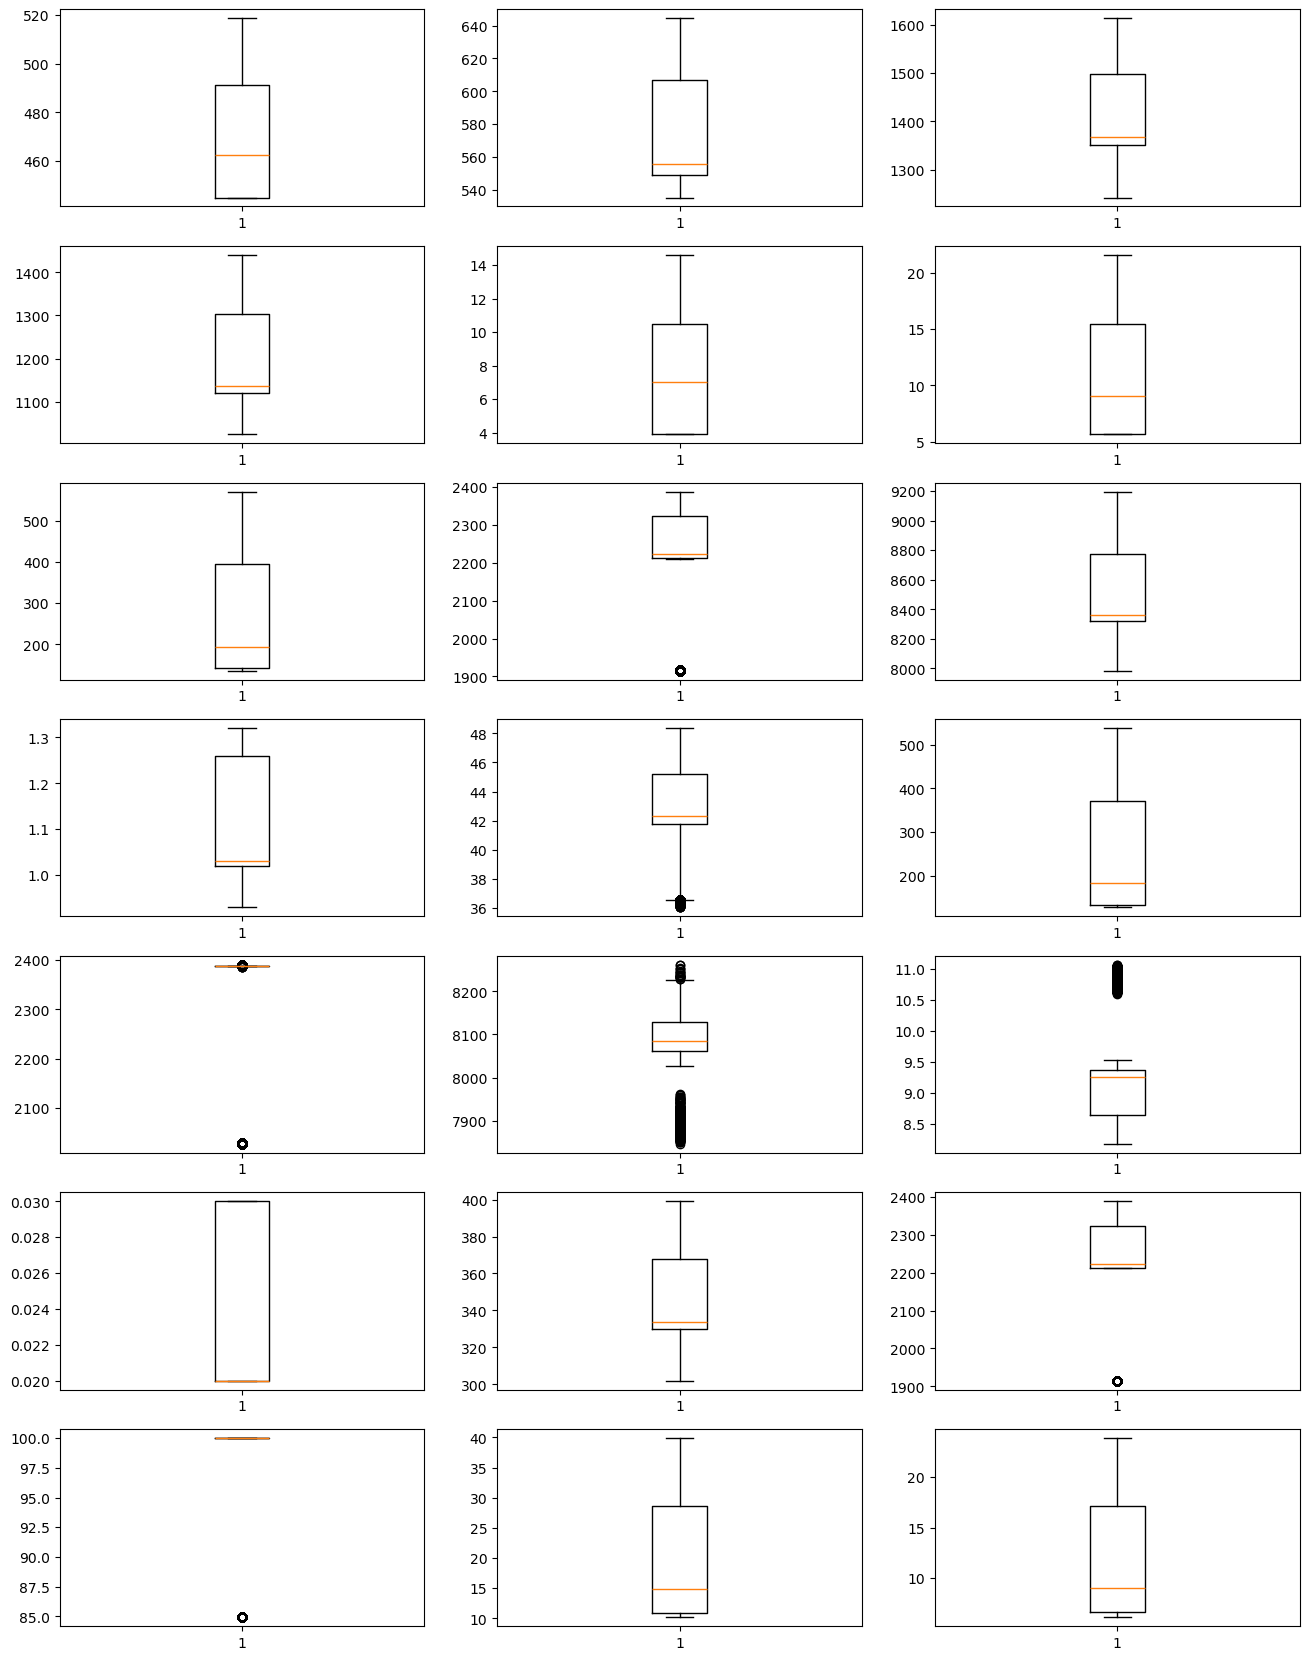

In [2]:
train_data = pd.read_csv("CMAPSSData/train_FD004.txt", sep= "\s+", header = None)
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train_data.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
plt.show()

In [3]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [4]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [5]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [6]:
test_data = pd.read_csv("CMAPSSData/test_FD004.txt", sep = "\s+", header = None)
true_rul = pd.read_csv('CMAPSSData/RUL_FD004.txt', sep = '\s+', header = None)

window_length = 1
shift = 1
early_rul = 130            
processed_train_data = []
processed_train_targets = []

num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

num_machines = np.min([len(train_data[0].unique()), len(test_data[0].unique())])

for i in np.arange(1, num_machines + 1):
    
    temp_train_data = train_data[train_data[0] == i].drop(columns=columns_to_be_dropped).values
    temp_test_data = test_data[test_data[0] == i].drop(columns=columns_to_be_dropped).values
    
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    elif (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)

    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)
processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (60994, 1, 14)
Processed training ruls shape:  (60994,)
Processed test data shape:  (1240, 1, 14)
True RUL shape:  (248,)


In [7]:
processed_train_data = processed_train_data.reshape(-1, processed_train_data.shape[2])
processed_test_data = processed_test_data.reshape(-1, processed_test_data.shape[2])
print("Processed train data shape: ", processed_train_data.shape)
print("Processed test data shape: ", processed_test_data.shape)

Processed train data shape:  (60994, 14)
Processed test data shape:  (1240, 14)


# Random Forest Regression

In [8]:
param_grid = {"n_estimators": [100, 200, 300, 400, 500, 1000],
              "max_features": ["sqrt", "log2"]}
grid = GridSearchCV(RandomForestRegressor(), param_grid = param_grid,scoring = "neg_root_mean_squared_error",
                    n_jobs = -1, cv = 10)
grid.fit(processed_train_data, processed_train_targets)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500, 1000]},
             scoring='neg_root_mean_squared_error')

In [9]:
grid.best_params_

{'max_features': 'sqrt', 'n_estimators': 1000}

In [10]:
best_rf_model = grid.best_estimator_
rul_pred_tuned = best_rf_model.predict(processed_test_data)

preds_for_each_engine_tuned = np.split(rul_pred_tuned, np.cumsum(num_test_windows_list)[:-1])

indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine_tuned)[indices_of_last_examples]

RMSE = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE)

RMSE (Taking only last examples):  30.090039080582258


In [11]:
def compute_s_score(rul_true, rul_pred):
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [12]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  8619.933476582524


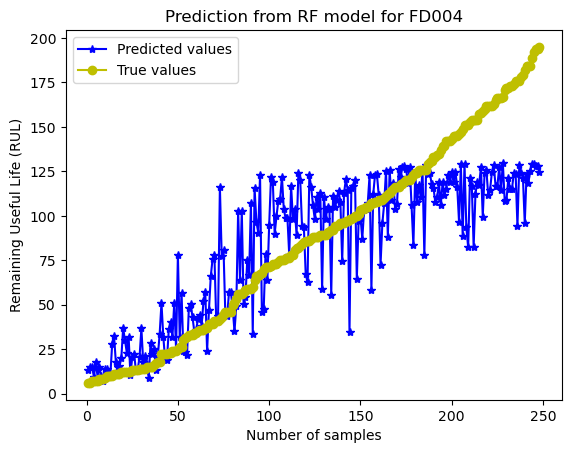

In [13]:
y_pred_series = pd.Series(preds_for_last_example.flatten())
y_test_series = pd.Series(true_rul.flatten())

df = pd.DataFrame({'y_pred_fd004': y_pred_series, 'y_test_fd004': y_test_series})

df = df.sort_values('y_test_fd004')

number_of_sample = range(1, len(true_rul) + 1)

plt.plot(number_of_sample, df['y_pred_fd004'], 'b*-', label='Predicted values')
plt.plot(number_of_sample, df['y_test_fd004'], 'yo-', label='True values')
plt.title('Prediction from RF model for FD004')
plt.xlabel('Number of samples')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()

plt.show()